In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
from os.path import join as pjoin
from glob import glob
sys.path.append('..')

In [21]:
import cv2
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from utils.commands import unzip, mkdir, call, count_file, KaggleCLI, execute_in, unzip_all
from utils.plot import plot_images, plot_confusion_matrix
from keras.callbacks import ModelCheckpoint
cli = KaggleCLI('dogs-vs-cats-redux-kernels-edition')

In [3]:
data_path = pjoin(os.getcwd(), 'data')
model_path = pjoin(os.getcwd(), 'models')
sample_path = pjoin(data_path, 'sample')
cal_path = pjoin(os.getcwd(), 'cal')
train_name = 'train'
valid_name = 'valid'
test_name = 'ttest'
best_weight_path = pjoin(model_path, 'weight.best.hdf5')

## Prepare Data for training

In [3]:
cli.download_data()

In [8]:
unzip_all(data_path)

In [4]:
mkdir(model_path)
categories = ['dog', 'cat']
for folder in [train_name, test_name, valid_name]:
    for ctg in categories:
        mkdir(pjoin(data_path, folder, ctg))
        mkdir(pjoin(sample_path, folder, ctg))

In [38]:
def move_data_to_category():
    call("mv cat.* cat")
    call('mv dog.* dog')

execute_in(pjoin(data_path, train_name), move_data_to_category)

In [39]:
def settle_data():
    train_cat, valid_cat, train_dog, valid_dog = train_test_split(os.listdir('train/cat'), os.listdir('train/dog'), test_size=0.2)
    valid_cat, test_cat, valid_dog, test_dog = train_test_split(valid_cat, valid_dog, test_size=0.4)
    
    strt = {
        train_name: {
            'dog': train_dog,
            'cat': train_cat,
        },
        valid_name: {
            'dog': valid_dog,
            'cat': valid_cat,
        },
        test_name: {
            'dog': test_dog,
            'cat': test_cat,
        }
    }
    
    for name, ds in strt.iteritems():
        if name == train_name:
            continue
        for ctg, data in ds.iteritems():
            for d in data:
                call('mv {} {}'.format(pjoin(train_name, ctg, d), pjoin(name, ctg)))
    
    for name, ds in strt.iteritems():
        for ctg, data in ds.iteritems():
            for d in data[:100]:
                call('cp {} {}'.format(pjoin(name, ctg, d), pjoin(sample_path, name, ctg)))
   

execute_in(data_path, settle_data)

## Training

In [25]:
work_path = data_path
train_path = pjoin(work_path, train_name)
valid_path = pjoin(work_path, valid_name)
test_path = pjoin(work_path, test_name)

In [26]:
from utils.pretrained_models import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [38]:
batch_size=32

### Fine tune vgg

In [12]:
vgg_model = VGG16.get_model(2).model

In [13]:
batch_size=32

train_flow = VGG16.get_data_gen(pjoin(work_path, train_name), batch_size).flow_from_directory(shuffle=True)
valid_flow = VGG16.get_data_gen(pjoin(work_path, valid_name), batch_size).flow_from_directory()
test_flow = VGG16.get_data_gen(pjoin(work_path, test_name), batch_size).flow_from_directory()

Found 20000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
for l in vgg_model.layers[:-1]:
    l.trainable = False

In [15]:
from keras.callbacks import ModelCheckpoint

train_steps = train_flow.samples // batch_size
valid_steps = valid_flow.samples // batch_size
epochs = 2

checkpointer = ModelCheckpoint(best_weight_path, save_best_only=True, verbose=1)

vgg_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
vgg_model.fit_generator(
        train_flow,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=valid_flow,
        validation_steps=valid_steps,
        callbacks=[checkpointer])

Epoch 1/2
625/625 [==============================] - 117s 187ms/step - loss: 0.1328 - acc: 0.9683 - val_loss: 0.0876 - val_acc: 0.9795

Epoch 00001: val_loss improved from inf to 0.08759, saving model to /media/newdrive/ZhaoyuWorkSpace/kaggle_fun/dogs_vs_cats_redux_kernels_edition/models/weight.best.hdf5
Epoch 2/2
625/625 [==============================] - 118s 189ms/step - loss: 0.1134 - acc: 0.9772 - val_loss: 0.0868 - val_acc: 0.9808

Epoch 00002: val_loss improved from 0.08759 to 0.08680, saving model to /media/newdrive/ZhaoyuWorkSpace/kaggle_fun/dogs_vs_cats_redux_kernels_edition/models/weight.best.hdf5


In [12]:
vgg_model.load_weights(pjoin(model_path, best_weight_name))
vgg_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
vgg_model.evaluate_generator(test_flow)

[0.08059582273506567, 0.982]

In [14]:
preds = vgg_model.predict_generator(test_flow)

### Tune Underfitting to Overfitting

In [6]:
vgg_model = VGG16.get_model(2).model
vgg_model.load_weights(best_weight_path)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
__________

In [7]:
from keras.layers import Conv2D
from keras.models import Sequential
last_conv_idx = [index for index,layer in enumerate(vgg_model.layers) 
                     if type(layer) is Conv2D][-1]

#### Split conv-layers and fc layers, try different strategies on tuning fc layers

In [27]:
conv_layers = vgg_model.layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

In [9]:
fc_layers = vgg_model.layers[last_conv_idx+1:]

In [28]:
train_flow = VGG16.get_data_gen(train_path).flow_from_directory()
valid_flow = VGG16.get_data_gen(valid_path).flow_from_directory()
test_flow = VGG16.get_data_gen(test_path).flow_from_directory()

Found 20000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


#### Precalculate conv-layers output, reuse it later

In [29]:
train_features = conv_model.predict_generator(train_flow)
valid_features = conv_model.predict_generator(valid_flow)

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(train_flow.classes.reshape(-1, 1))
train_labels = encoder.transform(train_flow.classes.reshape(-1, 1)).toarray()
valid_labels = encoder.transform(valid_flow.classes.reshape(-1, 1)).toarray()

In [31]:
import bcolz

def save_array(fname, arr):
    mkdir(fname)
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]


In [32]:
save_array(pjoin(cal_path, 'train_features.dat'), train_features)
save_array(pjoin(cal_path, 'valid_features.dat'), valid_features)
save_array(pjoin(cal_path, 'train_labels.dat'), train_labels)
save_array(pjoin(cal_path, 'valid_labels.dat'), valid_labels)

#### tunning with pretrained weight

In [36]:
# remove dropout, so all the weight have to be resize
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [37]:
train_features = load_array(pjoin(cal_path, 'train_features.dat'))
valid_features = load_array(pjoin(cal_path, 'valid_features.dat'))
train_labels = load_array(pjoin(cal_path, 'train_labels.dat'))
valid_labels = load_array(pjoin(cal_path, 'valid_labels.dat'))

In [42]:
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax'),
])
for l1,l2 in zip(fc_model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

In [43]:
opt = RMSprop(lr=0.00001, rho=0.7)
fc_model_path = pjoin(model_path, 'weight.fc.best.hdf5')
checkpointer = ModelCheckpoint(fc_model_path, save_best_only=True, verbose=1)
fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
fc_model.fit(train_features, train_labels, epochs=5, batch_size=32, validation_data=(valid_features, valid_labels))

Train on 20000 samples, validate on 3000 samples
Epoch 1/5
20000/20000 [==============================] - 48s 2ms/step - loss: 0.0508 - acc: 0.9857 - val_loss: 0.0580 - val_acc: 0.9827
Epoch 2/5
20000/20000 [==============================] - 47s 2ms/step - loss: 0.0165 - acc: 0.9960 - val_loss: 0.0751 - val_acc: 0.9830
Epoch 3/5
20000/20000 [==============================] - 47s 2ms/step - loss: 0.0059 - acc: 0.9990 - val_loss: 0.0904 - val_acc: 0.9847
Epoch 4/5
20000/20000 [==============================] - 47s 2ms/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.1179 - val_acc: 0.9840
Epoch 5/5
20000/20000 [==============================] - 47s 2ms/step - loss: 0.0039 - acc: 0.9997 - val_loss: 0.1049 - val_acc: 0.9840


In [44]:
conv_layers = vgg_model.layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
conv_model.add(fc_model)

In [46]:
conv_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
conv_model.evaluate_generator(test_flow)

[0.10536620428329024, 0.987]

#### Reduce overfitting, generalize better

##### Data augmentation

In [54]:
example_image = cv2.imread(pjoin(work_path, train_name, train_flow.filenames[50]))
resize_example = cv2.resize(example_image, (224, 224), interpolation=cv2.INTER_AREA)

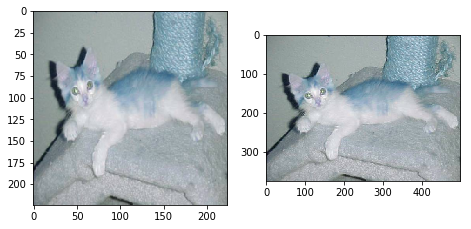

In [55]:
plot_images([resize_example, example_image])

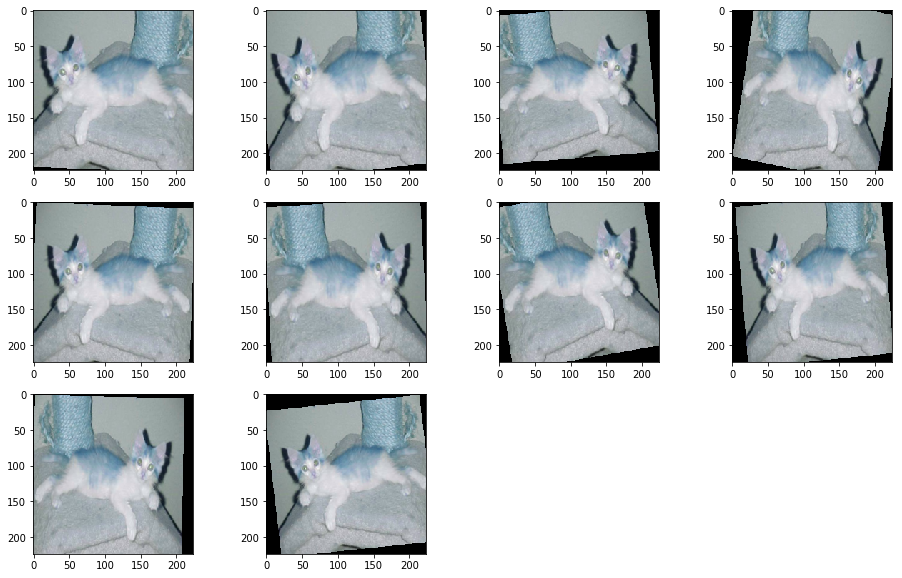

In [56]:
gen = ImageDataGenerator(horizontal_flip=True,
                         zoom_range=0.1,
                         height_shift_range=10,
                         width_shift_range=10,
                         rotation_range=10,
                         fill_mode='constant', cval=0)
image_iter = gen.flow(np.expand_dims(resize_example, axis=0))
plot_images([image_iter.next()[0].astype(np.uint8) for i in range(10)])

In [57]:
train_flow = VGG16.get_data_gen(train_path, batch_size, gen).flow_from_directory(shuffle=True)
valid_flow = VGG16.get_data_gen(valid_path, batch_size).flow_from_directory()

Found 20000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [59]:
for ly in conv_model.layers[:-1]: ly.trainable = False

In [66]:
opt = RMSprop(lr=0.00001, rho=0.7)
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
aug_model_path = pjoin(model_path, 'weight.best.aug.hdf5')
checkpointer = ModelCheckpoint(aug_model_path, save_best_only=True, verbose=1)
conv_model.fit_generator(
        train_flow,
        steps_per_epoch=train_steps,
        epochs=3,
        validation_data=valid_flow,
        validation_steps=valid_steps,
        callbacks=[checkpointer])

Epoch 1/1
625/625 [==============================] - 272s 436ms/step - loss: 0.0561 - acc: 0.9889 - val_loss: 0.1264 - val_acc: 0.9808


In [61]:
conv_model.load_weights(aug_model_path)
conv_model.evaluate_generator(test_flow)

[0.06084597279975537, 0.988]

##### r2, r1 regularzation

In [33]:
conv_model = Sequential(conv_layers)
for ly in conv_model.layers: ly.trainable = False

In [34]:
train_features = load_array(pjoin(cal_path, 'train_features.dat'))
valid_features = load_array(pjoin(cal_path, 'valid_features.dat'))
train_labels = load_array(pjoin(cal_path, 'train_labels.dat'))
valid_labels = load_array(pjoin(cal_path, 'valid_labels.dat'))

In [18]:
# remove dropout, so all the weight have to be resize
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [35]:
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.regularizers import l2
fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu', kernel_regularizer=l2(1), bias_regularizer=l2(0.01)),
    Dropout(0.),
    Dense(4096, activation='relu', kernel_regularizer=l2(1), bias_regularizer=l2(0.01)),
    Dropout(0.),
    Dense(2, activation='softmax', kernel_regularizer=l2(1), bias_regularizer=l2(0.01)),
])
for l1,l2 in zip(fc_model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

In [36]:
opt = RMSprop(lr=0.00001, rho=0.7)
fc_l2_model_path = pjoin(model_path, 'weight.fc.l2.best.hdf5')
checkpointer = ModelCheckpoint(fc_l2_model_path, save_best_only=True, verbose=1)
fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
fc_model.fit(train_features, train_labels, epochs=5, batch_size=32, validation_data=(valid_features, valid_labels))

Train on 20000 samples, validate on 3000 samples
Epoch 1/5
20000/20000 [==============================] - 71s 4ms/step - loss: 34.0256 - acc: 0.9775 - val_loss: 4.1820 - val_acc: 0.9747
Epoch 2/5
20000/20000 [==============================] - 63s 3ms/step - loss: 3.7412 - acc: 0.9809 - val_loss: 3.4404 - val_acc: 0.9750
Epoch 3/5
20000/20000 [==============================] - 63s 3ms/step - loss: 3.2382 - acc: 0.9810 - val_loss: 3.0798 - val_acc: 0.9750
Epoch 4/5
20000/20000 [==============================] - 63s 3ms/step - loss: 2.9632 - acc: 0.9806 - val_loss: 2.8732 - val_acc: 0.9770
Epoch 5/5
20000/20000 [==============================] - 63s 3ms/step - loss: 2.7874 - acc: 0.9810 - val_loss: 2.7341 - val_acc: 0.9693


In [ ]:
conv_model.add(fc_model)
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Analyze result 

In [15]:
print test_flow.class_indices
print test_flow.classes[:5]
print preds[:5]
print test_flow.filenames[:5]

{'dog': 1, 'cat': 0}
[0 0 0 0 0]
[[1.0000000e+00 3.9943141e-16]
 [9.9999726e-01 2.7315036e-06]
 [1.0000000e+00 2.3687397e-15]
 [1.0000000e+00 6.0425162e-15]
 [1.0000000e+00 5.0470037e-20]]
['cat/cat.10012.jpg', 'cat/cat.10025.jpg', 'cat/cat.10031.jpg', 'cat/cat.10044.jpg', 'cat/cat.1005.jpg']


In [16]:
filenames = test_flow.filenames
expected_labels = test_flow.classes
predict_labels = np.round(1-preds[:, 0])

In [17]:
def plot_by_idx(idx, titles=None):
    plot_images([cv2.imread(pjoin(work_path, test_name, filenames[ix])) for ix in idx], columns=5, titles=titles)

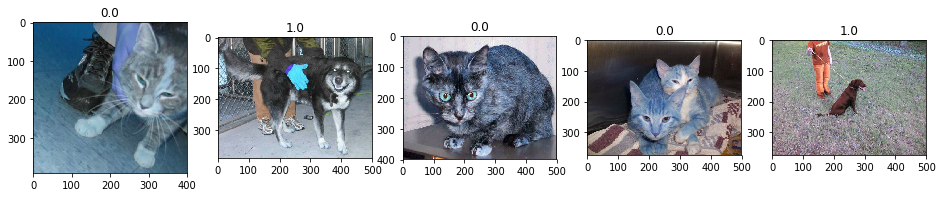

In [18]:
correct = np.where(predict_labels == expected_labels)[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

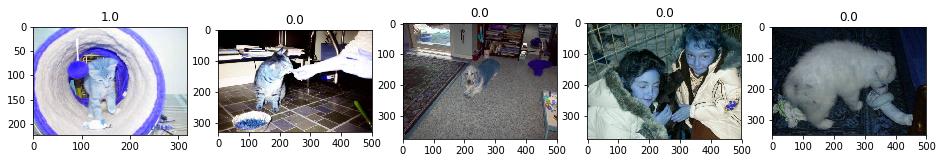

In [19]:
correct = np.where(predict_labels != expected_labels)[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

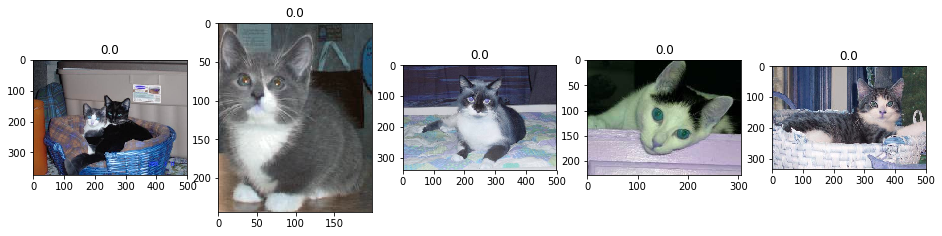

In [20]:
correct = np.where((predict_labels == expected_labels) & (predict_labels == 0))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

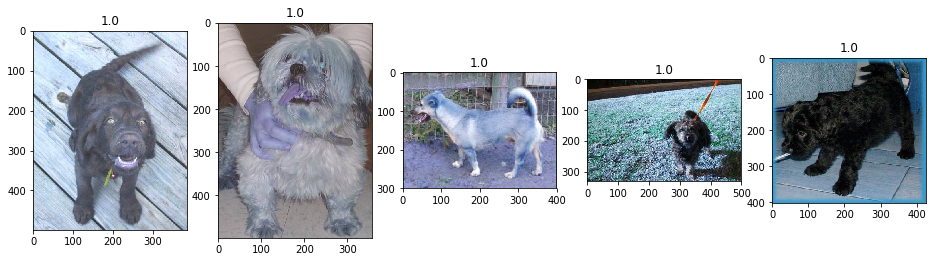

In [21]:
correct = np.where((predict_labels == expected_labels) & (predict_labels == 1))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

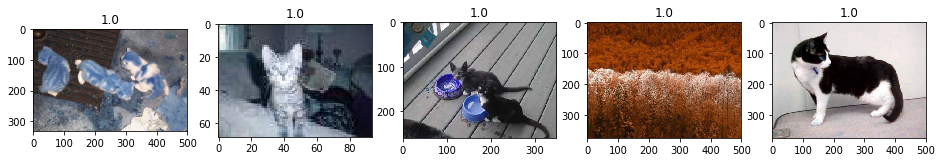

In [22]:
correct = np.where((predict_labels != expected_labels) & (predict_labels == 1))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

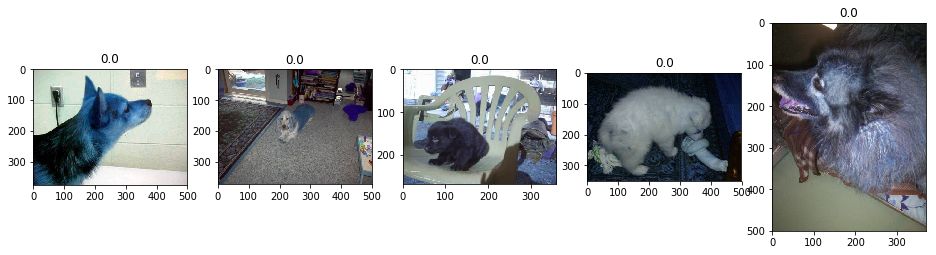

In [23]:
correct = np.where((predict_labels != expected_labels) & (predict_labels == 0))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

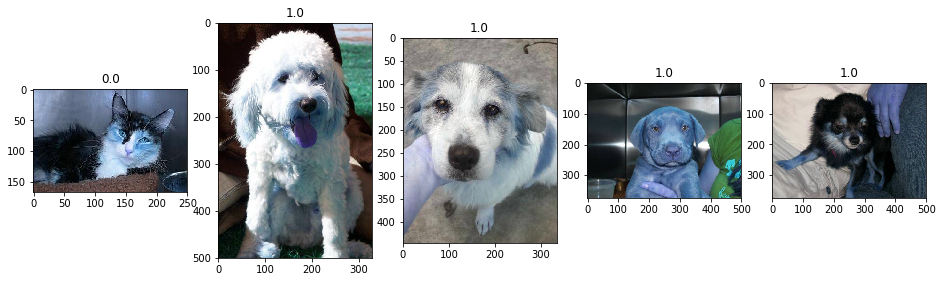

In [25]:
most_uncertain = np.argsort(np.abs(predict_labels-0.5))
plot_by_idx(most_uncertain[:5], predict_labels[most_uncertain])

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, predict_labels)

Confusion matrix, without normalization
[[977  23]
 [ 12 988]]


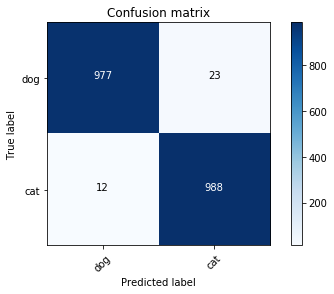

In [29]:
plot_confusion_matrix(cm, test_flow.class_indices)

## Generate submission file

In [39]:
submit_datagen = ImageDataGenerator()
submit_flow = submit_datagen.flow_from_directory(
        pjoin(work_path, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,)

result = conv_model.predict_generator(submit_flow)

Found 12500 images belonging to 1 classes.


In [63]:
isdog = result[:,1]
isdog = isdog.clip(min=0.2, max=0.98)
file_ids = np.array([int(f.split('.')[0].split('/')[1]) for f in submit_flow.filenames])
submit = np.stack([file_ids,isdog], axis=1)

In [64]:
submit_name = 'no_dropout_with_aug_submit.csv'
np.savetxt(submit_name, submit, fmt='%d,%.5f', header='id,label', comments='')

In [65]:
cli.submit_result(submit_name, 'vgg_finetune')